In [364]:
import os
import sys
sys.path.append(r'C:\Study\SpeechAcquisitionModel')
print(os.getcwd())
import numpy as np
from scipy.spatial.distance import euclidean, minkowski
from sklearn.metrics import precision_recall_curve, average_precision_score

import scipy
import torch

import dtw
import dtwalign
from fastdtw import fastdtw

from sklearn.manifold import TSNE
import pandas as pd

from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.siamese_net_sound_similarity.slstm_train import SiameseSpeechCommandsDataCollector, StochasticSiameseLSTMNet
from src.siamese_net_sound_similarity.train import SiameseLSTMNet
from src.siamese_net_sound_similarity.soft_dtw import SoftDTW


import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()
sns.set(font_scale=1.4, rc={'text.usetex' : False})
sns.set_style("whitegrid")

%matplotlib inline

C:\Study\SpeechAcquisitionModel\src\dtw


In [365]:
DISTANCE='euclidean'
STEP_PATTERN = 'typeIc'
CLOSED_END_STEP_PATTERN = "typeIc"
# DISTANCE=lambda x, y : minkowski(x,y, 1)

## Load data

In [366]:
wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left',
                'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']

wanted_words_combined = wanted_words

model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.02
}

In [367]:
preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'],
                                     winstep=model_settings['winstep'])

data_iter = SiameseSpeechCommandsDataCollector(preproc,
                                        data_dir=r'C:\Study\Speech_command_classification\speech_dataset',
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

index_to_word = {v:k for k,v in data_iter.word_to_index.items()}

In [368]:
n_mini_batch_size = 1
data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

duplicates = data_iter.get_duplicates(labels, 0, 'training')
assert np.any(labels == duplicates['y'])

non_duplicates = data_iter.get_nonduplicates(labels, 0, 'training')
assert np.any(labels != non_duplicates['y'])

Text(0.5,1,'negative DTW = 0.0548')

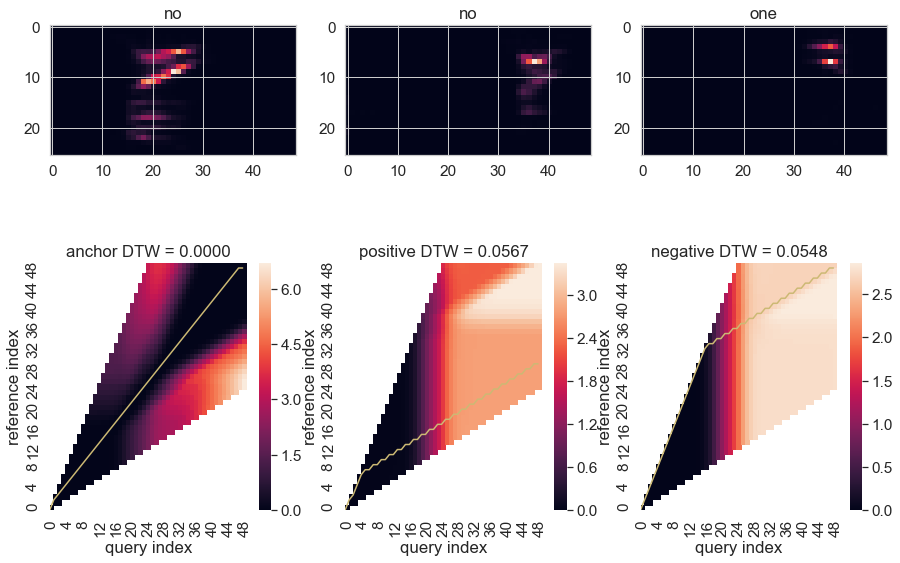

In [369]:

i = np.random.randint(data['y'].shape[0])
sample_idx = i

fig, axes = plt.subplots(2, 3, figsize=(15,10))

# plt.figure()
im = axes[0][0].imshow(data['x'][i].T)
# fig.colorbar(im)
label = index_to_word[data['y'][0]]
axes[0][0].title.set_text(f'{label}')

axes[0][1].imshow(duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[data['y'][0]]
axes[0][1].title.set_text(f'{label}')


axes[0][2].imshow(non_duplicates['x'][i].T)
# plt.colorbar()
label = index_to_word[non_duplicates['y'][0]]
axes[0][2].title.set_text(f'{label}')

######################################## DTW

x = data['x'][i]

# self dtw (extpected to be 0)

y = data['x'][i]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][0])
axes[1][0].set_title(f"anchor DTW = {res.normalized_distance:.4f}")


# positive dtw

y = duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][1])
axes[1][1].set_title(f"positive DTW = {res.normalized_distance:.4f}")


# negative dtw

y = non_duplicates['x'][sample_idx]
res = dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=True)
res.plot_path(ax=axes[1][2])
axes[1][2].set_title(f"negative DTW = {res.normalized_distance:.4f}")

# Gather Data for analysis

In [370]:
n_mini_batch_size = 10000
n_duplicates_size= 1000
# gather data


data = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels = data['y']

data1 = data_iter.get_data(n_mini_batch_size, 0, 'training')
labels1 = data1['y']

# duplicates = data_iter.get_duplicates(labels, 0, 'testing')
# assert np.any(labels == duplicates['y'])
# duplicates['x'] = duplicates['x'][:n_duplicates_size]
# print(duplicates['x'].shape)

# non_duplicates = data_iter.get_nonduplicates(labels, 0, 'testing')
# assert np.any(labels != non_duplicates['y'])

# y_true = np.concatenate((np.ones((n_duplicates_size)), np.zeros((n_mini_batch_size))))
y_true = labels==labels1
print(y_true)
print(labels)
print(labels1)
print(sum(y_true))

[False False False ... False False False]
[16. 17. 18. ... 13.  3. 27.]
[21. 26.  2. ... 16.  2.  3.]
347


## 1. MFCC Precision/Recall

In [371]:

# initialize dist_lists

dtw = []

for i in range(n_mini_batch_size):
    print(i, end='\r')
    x = data['x'][i].squeeze()
    y = data1['x'][i].squeeze()
    dtw.append(dtwalign.dtw(x, y, dist=DISTANCE, step_pattern=STEP_PATTERN, open_end=False, dist_only=True).normalized_distance)

mfcc_dtw_dist = np.array(dtw)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 2. Improving DTW using latent variables from LSTM classifier as a signal

In [372]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_10_03_2019_02_43_PM/net_0.484375.net'

nn = torch.load(nn_fname)

### 2.2 - SOFT-DTW

In [373]:
print(f"############################################################################\n\
# SOFT DTW\n\
############################################################################")

PREFIX_LENS = [50]

for PREFIX_LEN in PREFIX_LENS:
    print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
    nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()


    z, *_ = nn.single_forward(nn_input)
    z = z

    z1, *_ = nn.single_forward(torch.from_numpy(data1['x']).cuda().float())
    z1 = z1


    ###########################################################################
    # DTW
    ###########################################################################

    soft_dtw_loss_open_end = SoftDTW(open_end=True, dist='l1')
    soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')

    ##########################################################################
    # OPEN END = False
    ##########################################################################

    # initialize dist_lists

    dtw_z = []

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()
        y = z1[i].squeeze()
        
        d = soft_dtw_loss_close_end(x, y)
        dtw_z.append(d.detach().cpu().numpy())

    ce_dtw_dist = np.array(dtw_z)
  

############################################################################
# SOFT DTW
############################################################################
############################################################################
# PREFIX LENGTH : 50
############################################################################


# 3. Improving DTW using latent variables from L2-Triplet network

In [374]:
# load nn
nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_10_03_2019_05_09_PM/net_0.421875.net'


nn = torch.load(nn_fname)

### 3.2 - SOFT-DTW

In [375]:
print(f"############################################################################\n\
# SOFT DTW\n\
############################################################################")

PREFIX_LENS = [50]

for PREFIX_LEN in PREFIX_LENS:
    print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
    nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()


    z, *_ = nn.single_forward(nn_input)
    z = z

    z1, *_ = nn.single_forward(torch.from_numpy(data1['x']).cuda().float())
    z1 = z1


    ###########################################################################
    # DTW
    ###########################################################################

    soft_dtw_loss_open_end = SoftDTW(open_end=True, dist='l1')
    soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')

    ##########################################################################
    # OPEN END = False
    ##########################################################################

    # initialize dist_lists

    dtw_z = []

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()
        y = z1[i].squeeze()
        
        d = soft_dtw_loss_close_end(x, y)
        dtw_z.append(d.detach().cpu().numpy())

    ce_l2_dtw_dist = np.array(dtw_z)
   

############################################################################
# SOFT DTW
############################################################################
############################################################################
# PREFIX LENGTH : 50
############################################################################


# 4. Improving DTW using latent variables from DTW-Triplet network

In [376]:
# load nn

nn_fname = r'C:/Study/SpeechAcquisitionModel/reports/seamise_net_10_01_2019_03_37_PM/net_0.46875.net'

nn = torch.load(nn_fname)

### 4.2 - SOFT-DTW

In [377]:
print(f"############################################################################\n\
# SOFT DTW\n\
############################################################################")

PREFIX_LENS = [50]

for PREFIX_LEN in PREFIX_LENS:
    print(f"############################################################################\n\
# PREFIX LENGTH : {PREFIX_LEN}\n\
############################################################################")
    nn_input = torch.from_numpy(data['x'][:, :PREFIX_LEN, :]).cuda().float()


    z, *_ = nn.single_forward(nn_input)
    z = z

    z1, *_ = nn.single_forward(torch.from_numpy(data1['x']).cuda().float())
    z1 = z1


    ###########################################################################
    # DTW
    ###########################################################################

    soft_dtw_loss_open_end = SoftDTW(open_end=True, dist='l1')
    soft_dtw_loss_close_end = SoftDTW(open_end=False, dist='l1')

    ##########################################################################
    # OPEN END = False
    ##########################################################################

    # initialize dist_lists

    dtw_z = []

    for i in range(n_mini_batch_size):
        print(i, end='\r')
        x = z[i].squeeze()
        y = z1[i].squeeze()
        
        d = soft_dtw_loss_close_end(x, y)
        dtw_z.append(d.detach().cpu().numpy())

    ce_dtw_dtw_dist = np.array(dtw_z)
   

############################################################################
# SOFT DTW
############################################################################
############################################################################
# PREFIX LENGTH : 50
############################################################################


# 5. All Together

## 5.1 Precision_Recall Curve

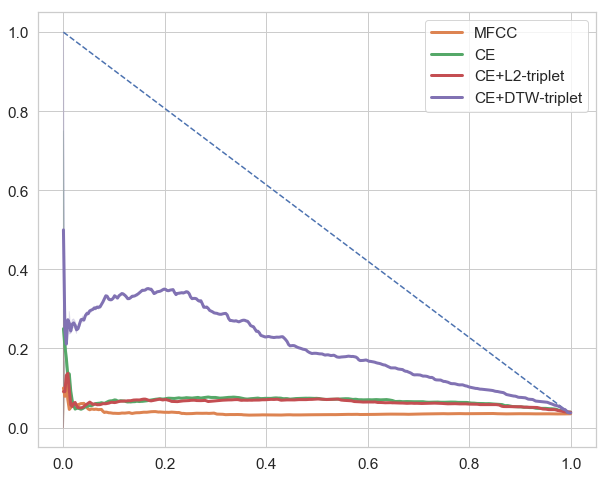

In [388]:
plt.figure(figsize=(10,8))

# no skill model
precision, recall, _ = precision_recall_curve(y_true, np.zeros(len(y_true)), pos_label=1)
ax = sns.lineplot(recall, precision)
ax.lines[0].set_linestyle("--")


models_dists = [mfcc_dtw_dist, ce_dtw_dist, ce_l2_dtw_dist, ce_dtw_dtw_dist]
model_names = ['MFCC', 'CE', 'CE+L2-triplet', 'CE+DTW-triplet']
for i in range(len(model_names)):
    precision, recall, thresholds = precision_recall_curve(y_true, -np.log(models_dists[i]), pos_label=1)
    sns.lineplot(recall, precision, label=model_names[i], linewidth=3)
plt.legend()
plt.show()

## 5.2 Average Precision 

In [387]:
models_dists = [mfcc_dtw_dist, ce_dtw_dist, ce_l2_dtw_dist, ce_dtw_dtw_dist]
model_names = ['MFCC', 'CE', 'CE+L2-triplet', 'CE+DTW-triplet']
for i in range(len(model_names)):
    average_precision = average_precision_score(y_true, -np.log(models_dists[i]))
    print(model_names[i], average_precision)
#     precision, recall, thresholds = precision_recall_curve(y_true, models_dists[i])

MFCC 0.03675203343530429
CE 0.06822081742200069
CE+L2-triplet 0.06432212660736862
CE+DTW-triplet 0.205069212876083
